In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pypsa

In [36]:
def annuity(n,r): # annuity factor
    return r/(1.-1./(1.+r)**n)*(r>0)+1/n*(r<=0)

plants = pd.read_csv('data/plants/plants.csv', sep = ';', index_col = 0, comment = '#')

In [37]:
switch = {'year': 2030,
          'fuel': 'NH3',
          'battery': True,
          'wind': True,
          'solar': True,
          'increase_demand': False,
          'connection': True,
          'location': 'Energy Island'}
country = {'DK': True,
           'DE': True,
           'NO': True,
           'NL': True,
           'GB': True}

In [43]:
# time index from year
t = pd.date_range('%d-01-01 00:00'%switch['year'], '%d-12-31 23:00'%switch['year'], freq = 'H')
# leap year
if (np.mod(switch['year'],100) != 0 and np.mod(switch['year'],4) == 0) or np.mod(switch['year'],400) == 0:
    t = t[:1416].union(t[1440:])

# weather data from refinement
cf = pd.DataFrame(index = t, columns = ['Wind','PV'])
cf['Wind'] = pd.read_csv('data/cf/wind_%s.csv'%plants['location'][switch['location']], index_col = 0).to_numpy()
cf['PV'] = pd.read_csv('data/cf/pv_%s.csv'%plants['location'][switch['location']], index_col = 0).to_numpy()

In [39]:
# efficiencies
eff = pd.Series(index = ['H2 Plant','NH3 Plant','H2 Engine','NH3 Engine','Battery'], dtype = float)
eff['H2 Plant'] = 141.8/(50*3.6)
eff['NH3 Plant'] = 23/(9.9*3.6)
eff['H2 Engine'] = 0.55
eff['NH3 Engine'] = 0.38
eff['Battery'] = 0.9216

# battery max charging hours
h_b = 6

# energy island fuel demand
load = pd.Series(np.full(np.shape(t)[0], 0.05*1.9e12/3.6/1000/8760), # MWh
                 index = t)
if switch['increase_demand']: load *= 1.015**(switch['year']-2030)

# offwind: 21 large turbines, off-shore
# onwind: 20 Large wind turbines on land
# pv: large scale utility systems (NO axis-tracking)
# H2: AEC 100MW
# NH3: no electrolyzer, ASU ?
if switch['year'] == 2030:
    n = np.array([30,30,40,30,30,25]) # expected lifetime
    r = np.array([0.07]) # constant discount rate
    costdata = pd.DataFrame(np.array([[1.93e6,1.04e6,3.8e5,4.5e5,1.3e6,1.42e5*h_b+1.6e5], # €/MW
                                      [36053,12600,7250,9000,39000,540], # €/MW/year
                                      [2.7,1.35,0.01,0.01,0.02,0]]), # €/MWh
                            index = ['Investment','FOM','VOM'],
                            columns = ['Offshore Wind','Onshore Wind','Solar PV','H2 Plant','NH3 Plant','Battery'])
elif switch['year'] == 2040: 
    n = np.array([30,30,40,32,30,30]) # expected lifetime
    r = np.array([0.07]) # constant discount rate
    costdata = pd.DataFrame(np.array([[1.81e6,9.8e5,3.3e5,3e5,1.1e6,9.4e4*h_b+1e5], # €/MW
                                      [33169,11592,6625,6000,32000,540], # €/MW/year
                                      [2.5,1.24,0.01,0.01,0.02,0]]), # €/MWh
                            index = ['Investment','FOM','VOM'],
                            columns = ['Offshore Wind','Onshore Wind','Solar PV','H2 Plant','NH3 Plant','Battery'])
elif switch['year'] == 2050: 
    n = np.array([30,30,40,35,30,30]) # expected lifetime
    r = np.array([0.07]) # constant discount rate
    costdata = pd.DataFrame(np.array([[1.78e6,9.6e5,3e5,2.5e5,8e5,7.5e4*h_b+6e4], # €/MW
                                      [32448,11340,6250,5000,24000,540], # €/MW/year
                                      [2.4,1.22,0.01,0.01,0.02,0]]), # €/MWh
                            index = ['Investment','FOM','VOM'],
                            columns = ['Offshore Wind','Onshore Wind','Solar PV','H2 Plant','NH3 Plant','Battery'])
ccost = annuity(n,r)*costdata.loc['Investment']+costdata.loc['FOM'] # €/MW

In [40]:
if switch['location'] == 'Energy Island':
    distance = {'DK': 81.5+223/5, # Thorsminde-DK[Odense] km https://www.mapdevelopers.com/distance_from_to.php
                'DE': 81.5+773.26/5, # Thorsminde-DE
                'NO': 200+441.3/5, # Kristiansand-NO
                'NL': 81.5+816.55/5, # Thorsminde-NL
                'GB': 327+1321.97/5} # Thorsminde-Rotterdam-Colchester

elif switch['location'] == 'DK Wind':
    distance = {'DK': 221.5/5, #  
                'DE': 771.14/5, #
                'NO': 466.5/5+182.32, # Hjørring-Larvik
                'NL': 814.19/5, # 
                'GB': 1322.88/5+245.5} # Rotterdam-Colchester
    
elif switch['location'] == 'DK Solar':
    distance = {'DK': 104.15/5, #  
                'DE': 500/5+50, # Lolland-Fehmarn
                'NO': 649.37/5+182.32, # Hjørring-Larvik
                'NL': 540/5+50, # Lolland-Fehmarn
                'GB': 1069.51/5+295.5} # Lolland-Fehmarn-Rotterdam-Colchester
    
elif switch['location'] == 'DE Wind':
    distance = {'DK': 495.15/5, #  
                'DE': 401.42/5, # 
                'NO': 931.39/5+182.32, # Hjørring-Larvik
                'NL': 296.54/5, # 
                'GB': 805.53/5+245.48} # Rotterdam-Colchester

elif switch['location'] == 'DE Solar':
    distance = {'DK': 1161.24/5, #  
                'DE': 516.3/5, # 
                'NO': 1598.65+182.32, # Hørring-Larvik
                'NL': 841.71/5, # 
                'GB': 1295.03/5+245.5} #
    
elif switch['location'] == 'NO Wind':
    distance = {'DK': 498.83/5+140.4, # Kristiansand-Hjørring 
                'DE': 1048.44+140.4, # 
                'NO': 485/5, # 
                'NL': 1088.87/5+140.4, # Kristiansand-Hjørring 
                'GB': 483.61/5+496.4} # Aberdeen
    
elif switch['location'] == 'NO Solar':
    distance = {'DK': 306.31/5+182.32, #  
                'DE': 856.04/5+182.32, # 
                'NO': 251.19/5, # 
                'NL': 900/5+182.32, # 
                'GB': 1403.88/5+427.79} # Hjørring-Rotterdam-Colchester 

elif switch['location'] == 'NL Wind':
    distance = {'DK': 674.93/5, #  
                'DE': 538.41/5, # 
                'NO': 1112.27/5+182.32, # Hjørring-Larvik
                'NL': 152.32/5, # 
                'GB': 605.46/5+245.48} # Rotterdam-Colchester
    
elif switch['location'] == 'NL Solar':
    distance = {'DK': 750.9/5, #  
                'DE': 582/5, # 
                'NO': 1188.27/5+182.32, # Hjørring-Larvik
                'NL': 124.44/5, # 
                'GB': 531.81/5+245.48} # Rotterdam-Colchester
    
elif switch['location'] == 'GB Wind':
    distance = {'DK': 931.79/5+245.48, # Colchester-Rotterdam
                'DE': 969.56/5+245.48, # Colchester-Rotterdam
                'NO': 1670.67/5+427.8, # Colchester-Rotterdam-Hjørring-Larvik
                'NL': 542.16/5+245.48, # Colchester-Rotterdam
                'GB': 87.28/5} # 
    
elif switch['location'] == 'GB Solar':
    distance = {'DK': 1013.33/5+84.13, # Dunkirk
                'DE': 652.75/5+84.13, # Dunkirk
                'NO': 1450.2/5+266.45, # Dunkirk-Hjørring-Larvik
                'NL': 332.71/5+84.13, # Dunkirk
                'GB': 505.98/5} # 

In [41]:
network = pypsa.Network()

network.set_snapshots(t)

network.add('Bus', 'Electricity')
network.add('Bus', 'H2')
network.add('Bus', 'NH3')

In [42]:
network.add('Load',
            'Fuel Demand', 
            bus = switch['fuel'], 
            p_set = load)

network.add('Store',
            'Free Tank',
            bus = switch['fuel'],
            e_nom_extendable = True,
            e_cyclic = True)

In [56]:
if switch['wind']:
    windname = 'Onshore Wind' if plants['onshore'][switch['location']] else 'Offshore Wind'
    network.add('Generator',
                windname,
                bus = 'Electricity',
                p_nom_extendable = True,
                p_nom_max = 10000,
                #p_nom_min = 5292.263671,
                capital_cost = ccost[windname],
                marginal_cost = costdata.loc['VOM'][windname],
                p_max_pu = cf['Wind'])

if switch['solar']:
    network.add('Generator',
                'Solar PV',
                bus = 'Electricity',
                p_nom_extendable = True,
                p_nom_max = 10000 if plants['onshore'][switch['location']] else 2000,
                #p_nom_min = 1139.036028,
                capital_cost = ccost['Solar PV'],
                marginal_cost = costdata.loc['VOM']['Solar PV'],
                p_max_pu = cf['PV'])

In [57]:
network.add('Link',
            'H2 Plant', 
            bus0 = 'Electricity',
            bus1 = 'H2',
            p_nom_extendable = True,
            #p_nom_min = 0,
            efficiency = eff['H2 Plant'],
            capital_cost = ccost['H2 Plant'],
            marginal_cost = costdata.loc['VOM']['H2 Plant']*eff['H2 Plant'])

network.add('Link',
            'NH3 Plant', 
            bus0 = 'Electricity',
            bus1 = 'NH3',
            p_nom_extendable = True,
            #p_nom_min = 5319.719576,
            efficiency = eff['NH3 Plant'],
            capital_cost = ccost['NH3 Plant'],
            marginal_cost = costdata.loc['VOM']['NH3 Plant']*eff['NH3 Plant'])

In [58]:
if switch['battery']:
    network.add('StorageUnit',
                'Battery',
                bus = 'Electricity',
                cyclic_state_of_charge = True,
                p_nom_extendable = True,
                p_nom_max = 800,
                #p_nom_min = 0,
                capital_cost = ccost['Battery'],
                marginal_cost = costdata.loc['VOM']['Battery'],
                efficiency_store = eff['Battery'],
                efficiency_dispatch = eff['Battery'],
                max_hours = h_b)

In [63]:
# Countries
if switch['connection']:
    mcost = pd.read_csv('data/market/price_%d.csv'%switch['year'], index_col = 0).set_index(t)
    load = pd.read_csv('data/market/load_%d.csv'%switch['year'], index_col = 0).set_index(t)
    for i in country.keys():
        if country[i]:
            network.add('Bus', i)
            network.add('Bus', i+' Hub')
            
            network.add('Generator',
                        'Elec_'+i,
                        bus = i,
                        p_nom_extendable = True,
                        marginal_cost = mcost[i])
            network.add('Load',
                        'Load_'+i, 
                        bus = i, 
                        p_set = load[i])
            
            # 5 links
            network.add('Link',
                        'Energy Island to %s Hub'%i, 
                        bus0 = 'Electricity',
                        bus1 = i+' Hub',
                        p_nom_extendable = True,
                        efficiency = 0.95,
                        marginal_cost = 0.01)
            network.add('Link',
                        '%s Hub to Energy Island'%i,
                        bus0 = i+' Hub',
                        bus1 = 'Electricity',
                        p_nom_extendable = True,
                        efficiency = 0.95,
                        marginal_cost = 0.01)
            network.add('Link',
                        '%s and %s Hub'%(i,i), 
                        bus0 = i,
                        bus1 = i+' Hub',
                        p_nom_extendable = True,
                        p_min_pu = -1,
                        capital_cost = (annuity(40,0.07)+0.02)*(2000*distance[i]+150000)) # marta

In [64]:
network.lopf(network.snapshots,
             #pyomo = False,
             #extra_functionality = extra_functionality,
             solver_name = 'gurobi')

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x254067_copy
  Lower bound: 52463867063.67835
  Upper bound: 52463867063.67835
  Number of objectives: 1
  Number of constraints: 595681
  Number of variables: 254067
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 254067
  Number of nonzeros: 1195683
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminat

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

In [65]:
LFC = 'higher'
if not switch['connection']:
    totalcost = network.objective
else:
    totalcost = (sum(network.generators.capital_cost*network.generators.p_nom_opt
                     +network.generators.marginal_cost*network.generators_t.p.sum())
                 +sum(network.storage_units.capital_cost*network.storage_units.p_nom_opt
                      +network.storage_units.marginal_cost*abs(network.storage_units_t.p).sum()))
                 #-np.multiply(network.generators_t.marginal_cost,
                              #network.links_t.p0.filter(like = 'Energy Island')).to_numpy().sum())
    if LFC == 'higher':
        totalcost += sum(network.links.capital_cost*network.links.p_nom_opt
                         +network.links.marginal_cost*abs(network.links_t.p0).sum())
    elif LFC == 'lower':
        totalcost += (network.links.capital_cost*network.links.p_nom_opt
                      +network.links.marginal_cost*abs(network.links_t.p0).sum()).filter(like = 'Plant').sum()

In [66]:
totalcost+(network.generators_t.marginal_cost*network.generators_t.p.filter(like = 'Elec')).values.sum()

52463867063.70476

In [67]:
network.objective

52463867063.67835

In [68]:
network.buses_t.marginal_price

,Electricity,H2,NH3,DK,DK Hub,DE,DE Hub,NO,NO Hub,NL,NL Hub,GB,GB Hub
2030-01-01 00:00:00,29.424236,37.360934,90.191718,27.943024,27.943024,28.206890,28.206890,30.983406,30.983406,28.206550,28.206550,27.959920,27.959920
2030-01-01 01:00:00,26.558216,33.722827,90.191718,16.801210,25.220305,27.966543,27.966543,27.966543,27.966543,27.966543,27.966543,27.940243,27.940243
2030-01-01 02:00:00,17.696418,22.473718,90.191718,16.801597,16.801597,18.638335,18.638335,18.638335,18.638335,27.964214,18.638335,15.072276,16.801597
2030-01-01 03:00:00,17.679319,22.452013,90.191718,16.785353,16.785353,18.620336,18.620336,18.620336,18.620336,18.620336,18.620336,14.671050,16.785353
2030-01-01 04:00:00,14.350564,18.226513,90.191718,13.623036,13.623036,15.116384,15.116384,15.116384,15.116384,15.116384,15.116384,12.214202,13.623036
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030-12-31 19:00:00,39.297556,49.894063,90.191718,37.322678,37.322678,54.117153,41.376375,37.310775,37.322678,53.532007,41.376375,27.964672,37.322678
2030-12-31 20:00:00,39.285019,49.878149,90.191718,40.081408,40.081408,54.105666,41.363178,37.310768,37.310768,40.082063,40.082063,27.964764,37.310768
2030-12-31 21:00:00,39.285015,49.878143,90.191718,40.160766,40.160766,54.105409,41.363173,37.310764,37.310764,40.159805,40.159805,27.965261,37.310764
2030-12-31 22:00:00,39.285009,49.878136,90.191718,40.110650,40.110650,41.363168,41.363168,37.310759,37.310759,40.110998,40.110998,27.982731,37.310759


In [69]:
network.generators_t.marginal_cost

,Elec_DK,Elec_DE,Elec_NO,Elec_NL,Elec_GB
2030-01-01 00:00:00,27.943024,28.206890,37.310587,28.206550,27.959920
2030-01-01 01:00:00,16.801210,27.966856,37.310597,27.966543,27.940243
2030-01-01 02:00:00,16.801597,27.964969,37.310592,27.964214,15.072276
2030-01-01 03:00:00,16.785353,27.964808,37.310579,27.963583,14.671050
2030-01-01 04:00:00,13.623036,27.964750,37.310573,27.963149,12.214202
...,...,...,...,...,...
2030-12-31 19:00:00,37.322678,54.117153,37.310775,53.532007,27.964672
2030-12-31 20:00:00,40.081408,54.105666,37.310768,40.082063,27.964764
2030-12-31 21:00:00,40.160766,54.105409,37.310764,40.159805,27.965261
2030-12-31 22:00:00,40.110650,54.105023,37.310759,40.110998,27.982731


In [70]:
network.objective/network.loads_t.p.values.sum()

52.3790891025631

In [ ]:
totalcost/network.loads_t.p['Fuel Demand'].sum() # €/MWh

In [ ]:
totalcost/(network.loads_t.p['Fuel Demand'].sum()*eff[switch['fuel']+' Engine']) # €/MWh

In [71]:
network.generators.p_nom_opt # in MW

Offshore Wind     10000.000000
Solar PV           2000.000000
Elec_DK           58290.130000
Elec_DE          110063.369530
Elec_NO           47459.656351
Elec_NL           26129.012326
Elec_GB           70939.010959
Name: p_nom_opt, dtype: float64

In [72]:
network.storage_units.p_nom_opt

Battery    0.0
Name: p_nom_opt, dtype: float64

In [73]:
network.links.p_nom_opt # in MW

H2 Plant                       0.000000
NH3 Plant                   5883.343017
Energy Island to DK Hub     5393.296581
DK Hub to Energy Island    53106.752982
DK and DK Hub              53106.752982
Energy Island to DE Hub    42738.013872
DE Hub to Energy Island    40601.113178
DE and DE Hub              40601.113178
Energy Island to NO Hub    18536.737685
NO Hub to Energy Island    29221.979319
NO and NO Hub              29221.979319
Energy Island to NL Hub     9874.276392
NL Hub to Energy Island     9380.562572
NL and NL Hub               9380.562572
Energy Island to GB Hub    26857.307897
GB Hub to Energy Island    25514.442502
GB and GB Hub              25514.442502
Name: p_nom_opt, dtype: float64

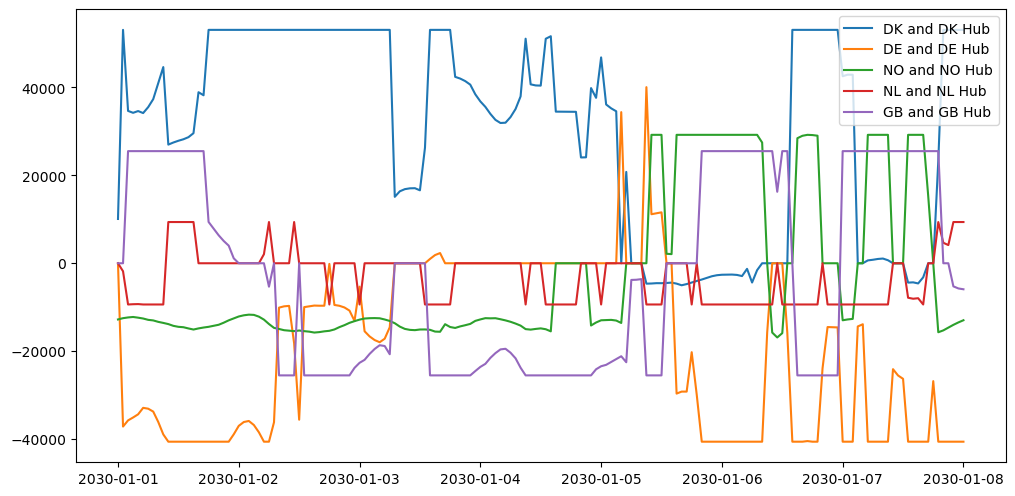

In [81]:
plt.figure(figsize=(12,6),dpi=100)
plt.plot(network.links_t.p0.filter(like=' and ')['%d-01-01 00:00'%switch['year']:'%d-01-08 00:00'%switch['year']])
plt.legend(labels=network.links_t.p0.filter(like=' and ').columns)
plt.show()